In [1]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [2]:
multiclass_train = pd.read_csv("multiclass_train.csv")
multiclass_test = pd.read_csv("multiclass_test.csv")

In [3]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass_train[" Label"] = le.fit_transform(multiclass_train[" Label"].values)

multiclass_test[" Label"] = le.transform(multiclass_test[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass_train[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [4]:
y_train = multiclass_train[" Label"].copy()
X_train = multiclass_train.drop([" Label"], axis=1)

y_test = multiclass_test[" Label"].copy()
X_test = multiclass_test.drop([" Label"], axis=1)

In [5]:
scal = StandardScaler()
scal = scal.fit(X_train)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, stratify=y_train, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [6]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), 1, n_feat))
X_vl = np.reshape(X_val, (len(X_val), 1, n_feat))
X_tst = np.reshape(X_test, (len(X_test), 1, n_feat))

In [7]:
print(X_tr.shape)
print(y_train.shape)

(139993, 1, 80)
(139993,)


In [17]:
model = keras.Sequential()
model.add(keras.Input(shape=(1, n_feat)))
model.add(LSTM(512, activation=tfa.activations.gelu, return_sequences=True))

model.add(Flatten())
model.add(Dense(256, activation=tfa.activations.gelu))
model.add(Dense(64, activation=tfa.activations.gelu))
model.add(Dense(32, activation=tfa.activations.gelu))
model.add(Dense(12, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 512)            1214464   
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 12)                396       
                                                                 
Total params: 1,364,716
Trainable params: 1,364,716
No

In [18]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=512, epochs=50, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/50
274/274 [==============================] - 5s 13ms/step - loss: 1.0691 - sparse_categorical_accuracy: 0.5392 - val_loss: 0.7619 - val_sparse_categorical_accuracy: 0.6230 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 3s 11ms/step - loss: 0.7399 - sparse_categorical_accuracy: 0.6278 - val_loss: 0.7181 - val_sparse_categorical_accuracy: 0.6350 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - 3s 11ms/step - loss: 0.7135 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.7039 - val_sparse_categorical_accuracy: 0.6351 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 3s 11ms/step - loss: 0.7009 - sparse_categorical_accuracy: 0.6382 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.6316 - lr: 0.0010
Epoch 5/50
274/274 [==============================] - 3s 11ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.6417 - val_loss: 0.6857 - val_sparse_categorical_accuracy: 0.6413 - lr: 0.0010
Epoch 6/50
274/274 [==========

In [19]:
path_new_model = "LSTM_multiclass_final.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


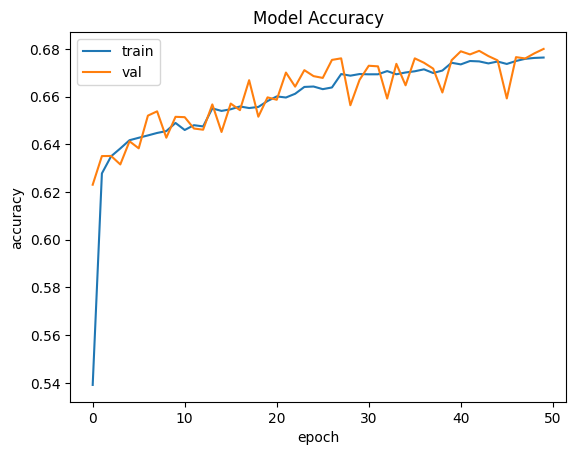

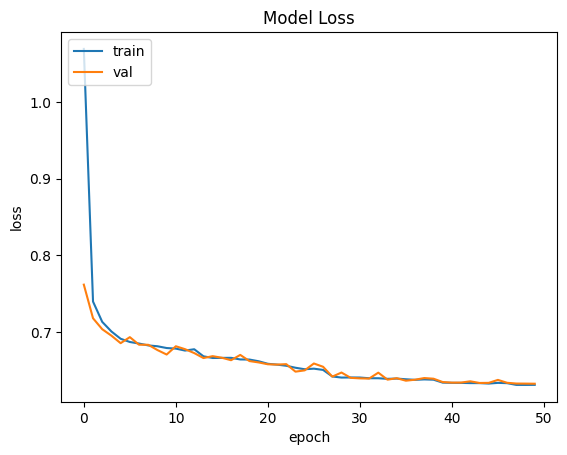

In [20]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
#Test predictions
#model.load_weights(checkpoint_filepath)
prediction = model.predict(X_tst)

1250/1250 [==============================] - 3s 2ms/step


In [25]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

5     5550
10    4840
11    4350
6     4232
1     4229
2     3448
3     3350
9     3329
7     2142
8     1842
0     1442
4     1245
dtype: int64

In [26]:
print(classification_report(y_test.to_numpy(), pred, digits=6,target_names=multiclass_labels))

              precision    recall  f1-score   support

         DNS   0.638696  0.276328  0.385759      3333
        LDAP   0.529676  0.672067  0.592436      3333
       MSSQL   0.896172  0.927093  0.911370      3333
         NTP   0.985672  0.990402  0.988031      3334
     NetBIOS   0.559839  0.209121  0.304500      3333
     Portmap   0.505766  0.842184  0.631994      3333
        SNMP   0.660208  0.838032  0.738567      3334
        SSDP   0.479925  0.308338  0.375457      3334
         Syn   0.995114  0.549955  0.708406      3333
        TFTP   0.991289  0.990099  0.990693      3333
         UDP   0.478719  0.695170  0.566989      3333
     UDP-lag   0.648736  0.846685  0.734609      3333

    accuracy                       0.678792     39999
   macro avg   0.697484  0.678789  0.660734     39999
weighted avg   0.697485  0.678792  0.660737     39999



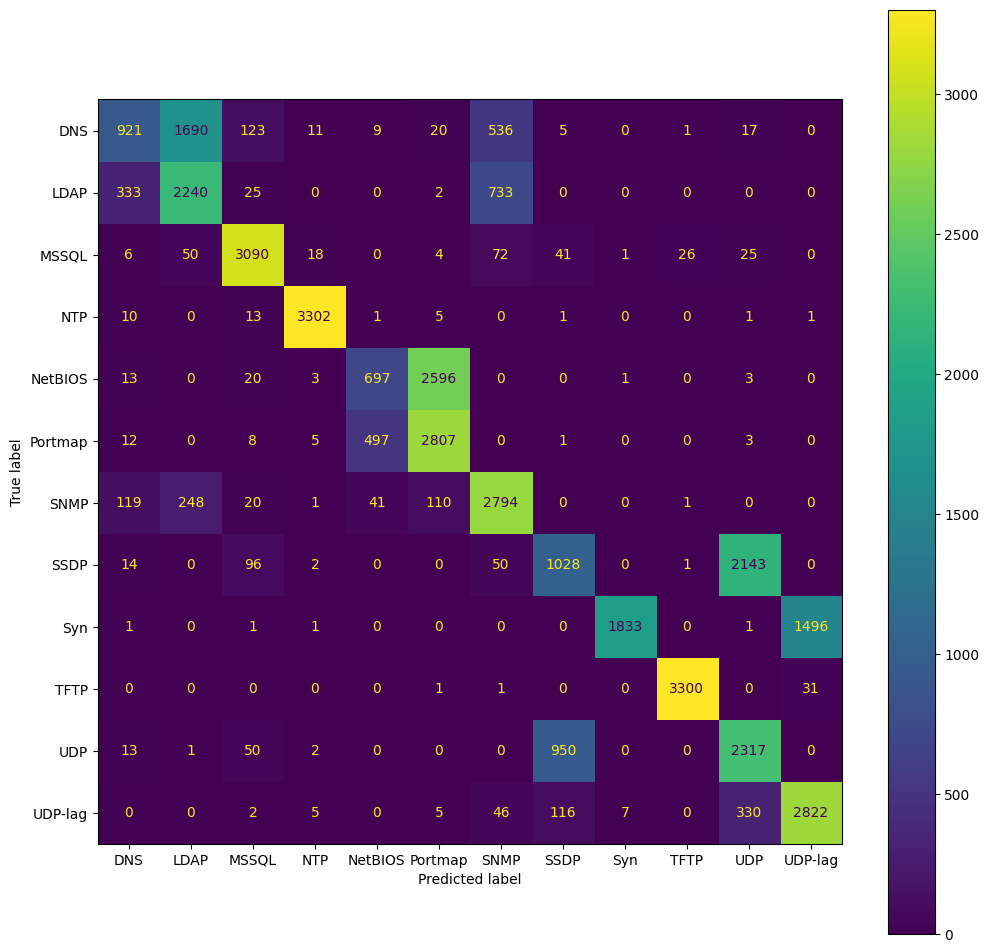

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_big.png")